In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import pandas as pd
import itertools
import seaborn as sns

In [2]:
import seaborn as sns
import json
import pandas as pd
import numpy as np

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# plt.rcParams['axes.linewidth'] = 2.0 #set the value globally
# sns.set(style="whitegrid")
sns.set_style("whitegrid")
# Load results
sns.set(font_scale=1.7)
sns.set_style("darkgrid")

def read_json(path):
    validation = []
    with open(path, "r") as f:
        for line in f:
            line=line.strip().replace("'", '"')
            line = line.replace("nan", '"nan"')
            try:
                data = json.loads(line)
            except:
                print(line)
                raise
            if data['_meta']['type'] == 'validation':
                validation.append(data)
    return validation

                    
def transform(entry, atk, agg, m, s, d, b, bz):
    if "large" in atk:
        atk_name = r"IPM ($\epsilon = 100$)"
    elif atk == "IPM":
        atk_name = r"IPM ($\epsilon = 0.5$)"
    else:
        atk_name = atk
        
    if b == 0:
        atk_name = "No Attack"
        
    return {
        'Round Number': entry['E'],
        'Accuracy (%)': entry['top1'],
        'ATK': atk_name,
        "Loss": entry['Loss'], 
        "Batch Size": bz,
        'Setting': d.replace('f', 'F', 1),
        'AGG': fedavg_methods[agg]['name'],
        r"$\beta$": m,
        'seed': s,
        r"$M$" : b,
        r"$\delta=0$": False,
    }

b=8

attacks = ["Noise", "BF", "LF", "IPM", 'IPM_large', "ALIE"]
aggs = ["avg", "krum", 'rfa', "autogm", "cm", "tm", "cp", "clustering", 'clippedclustering']
aggs = ["krum", 'rfa', "autogm", "cm", "tm", "cp", "clustering", 'clippedclustering']

fedavg_methods = {
    'avg' : {'name' : 'Mean', 'marker' : '^'}, 
    'rfa' : {'name' : 'GeoMed', 'marker' : 's'}, 
    'autogm' : {'name' : 'AutoGM', 'marker' : 's'}, 
    'krum' : {'name' : 'Krum', 'marker' : '|'}, 
    'cp' : {'name' : 'CC', 'marker' : 'p'}, 
    'cm': {'name' : 'Median', 'marker' : 'D'}, 
    'tm' : {'name' : 'TrimmedMean', 'marker' : '8'}, 
    'clustering' : {'name' : 'Clustering', 'marker' : 'o'}, 
    'clippedclustering' : {'name' : 'ClippedClustering', 'marker' : 'v'}
}

col_order = [fedavg_methods[k]['name'] for k in aggs]

def append_loop_path(bs, seeds, attacks, aggs, ms, dir_name, data_collection, ROOT_PATH, bzs=None):
    if not bzs:
        bzs = [32]
    for bz in bzs:
        for b in bs:
            for seed in seeds: 
                for attack in attacks:
                    for agg in aggs:
                        for m in ms:
                            try:
                                batch_size = '_bz' + str(bz) if bz != 32 else ""
                                path = ROOT_PATH.format(d=dir_name, f=b, atk=attack, agg=agg, m=m, b=b, bz=batch_size, s=seed)
#                                 print(path)
                                data_collection[path] = read_json(path)
                                if len(data_collection[path]) < 150:
                                    print(path)
                            except Exception as e:
                                print(e)
                                raise 
    return data_collection

def append_loop_df(bs, seeds, attacks, aggs, ms, dir_name, df, ROOT_PATH, data_collection, bzs=None):
    if not bzs:
        bzs = [32]
    for bz in bzs:
        for b in bs:
            for seed in seeds: 
                for attack in attacks:
                    for agg in aggs:
                        for m in ms:
                            try:
                                batch_size = '_bz' + str(bz) if bz != 32 else ""
                                path = ROOT_PATH.format(d=dir_name, f=b, atk=attack, agg=agg, m=m, b=b, bz=batch_size, s=seed)
                                validation_entries = data_collection[path]
                                df += list(map(lambda x: transform(x, atk=attack, agg=agg, m=m, s=seed, d=dir_name, b=b, bz=bz), validation_entries))
                            except Exception as e:
                                print("Error", e)
                                raise
    return df

def plot_all(dir_name, num_round=7500):
    ROOT_PATH="../outputs/{d}/f{f}_{atk}_{agg}_m{m}_b{b}_seed{s}/stats" #% (dir_name)
    data_collection = {}
    
    data_collection = append_loop_path(bs=[8], seeds=[0], attacks=attacks, aggs=aggs, 
                    ms=[0.0], dir_name=dir_name, data_collection=data_collection, ROOT_PATH=ROOT_PATH)

    
    data_collection = append_loop_path(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=aggs, 
                    ms=[0.0], dir_name=dir_name, data_collection=data_collection, ROOT_PATH=ROOT_PATH)


    df = []
    df = append_loop_df(bs=[8], seeds=[0], attacks=attacks, aggs=aggs, 
                    ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection)
    df = pd.DataFrame(df)
    
    
    df_noattack = []
    df_noattack = append_loop_df(bs=[0], seeds=[0], attacks=['IPM_large'], aggs=aggs, 
            ms=[0.0], dir_name=dir_name, df=df_noattack, ROOT_PATH=ROOT_PATH, data_collection=data_collection)
    df_noattack = pd.DataFrame(df_noattack)

    
    data = pd.concat([df_noattack, df],ignore_index=True)
    
    data.loc[(data["Setting"] == "Fedsgd_iid") | (data["Setting"] == "Fedsgd_noniid"), "Round Number"] *= 50
    data["Communication Rounds"] = data["Round Number"]
    g = sns.relplot(
        data=data, 
        x="Communication Rounds", y="Accuracy (%)", 
        col="AGG", 
    #     row=r"$\beta$", 
        hue="ATK", 
    #     style=r"$\delta=0$",
        height=4.5, aspect=1.25,
        col_order=col_order,
        markers=True,
        col_wrap=4,
        
        linewidth = 3.0,
        kind="line"
    )
#     g.set(xlim=(0, num_round))


    sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.05), ncol=8, title=None, frameon=False)

    g.savefig(dir_name + ".pdf", bbox_inches = "tight") 

In [10]:
plot_all("fedavg_noniid", 400)

[Errno 2] No such file or directory: '../outputs/fedavg_noniid/f8_Noise_krum_m0.0_b8_seed0/stats'


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/fedavg_noniid/f8_Noise_krum_m0.0_b8_seed0/stats'

../outputs/fedavg_iid/f8_Noise_clustering_m0.0_b8_seed0/stats


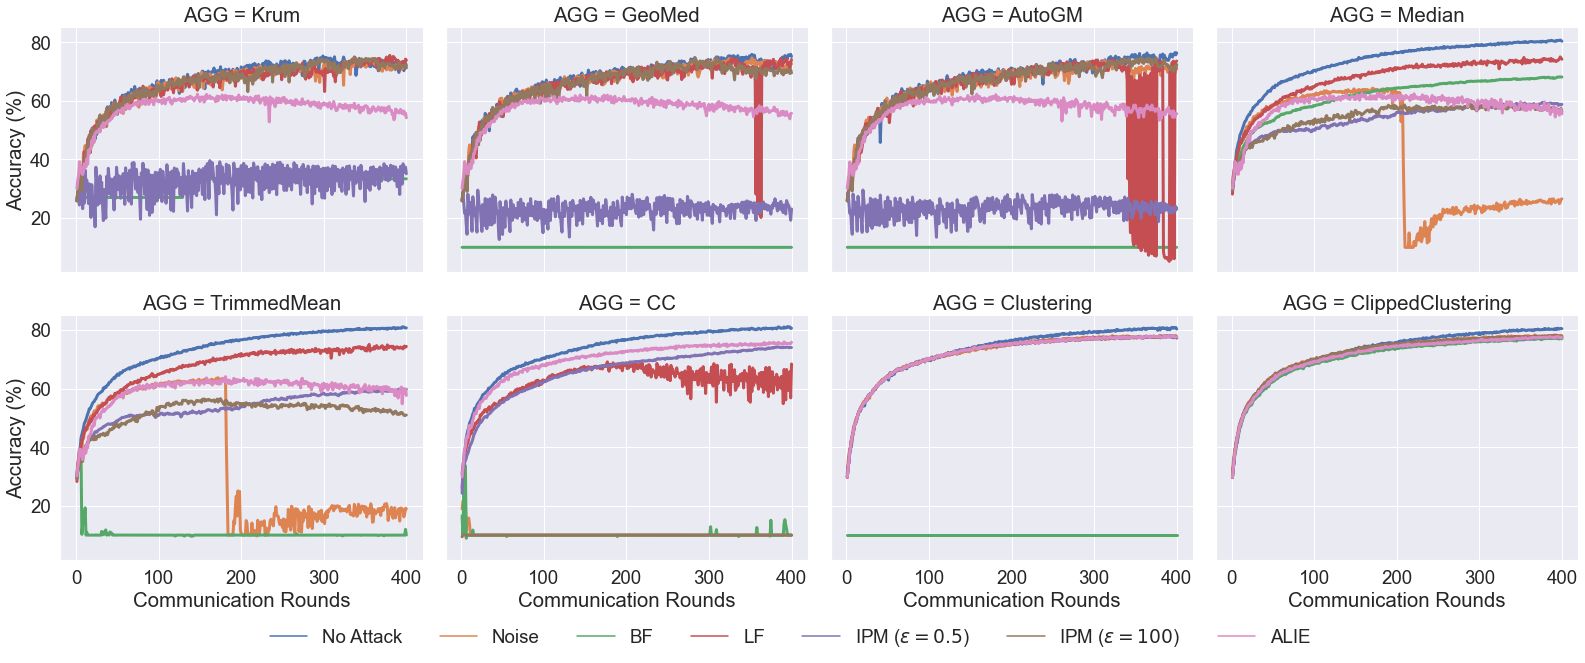

In [37]:
plot_all("fedavg_iid", 400)

../outputs/fedsgd_noniid/f8_Noise_krum_m0.0_b8_seed0/stats
../outputs/fedsgd_noniid/f8_IPM_krum_m0.0_b8_seed0/stats
../outputs/fedsgd_noniid/f8_IPM_rfa_m0.0_b8_seed0/stats
../outputs/fedsgd_noniid/f8_IPM_large_clustering_m0.0_b8_seed0/stats
../outputs/fedsgd_noniid/f8_ALIE_clustering_m0.0_b8_seed0/stats
../outputs/fedsgd_noniid/f8_ALIE_clippedclustering_m0.0_b8_seed0/stats


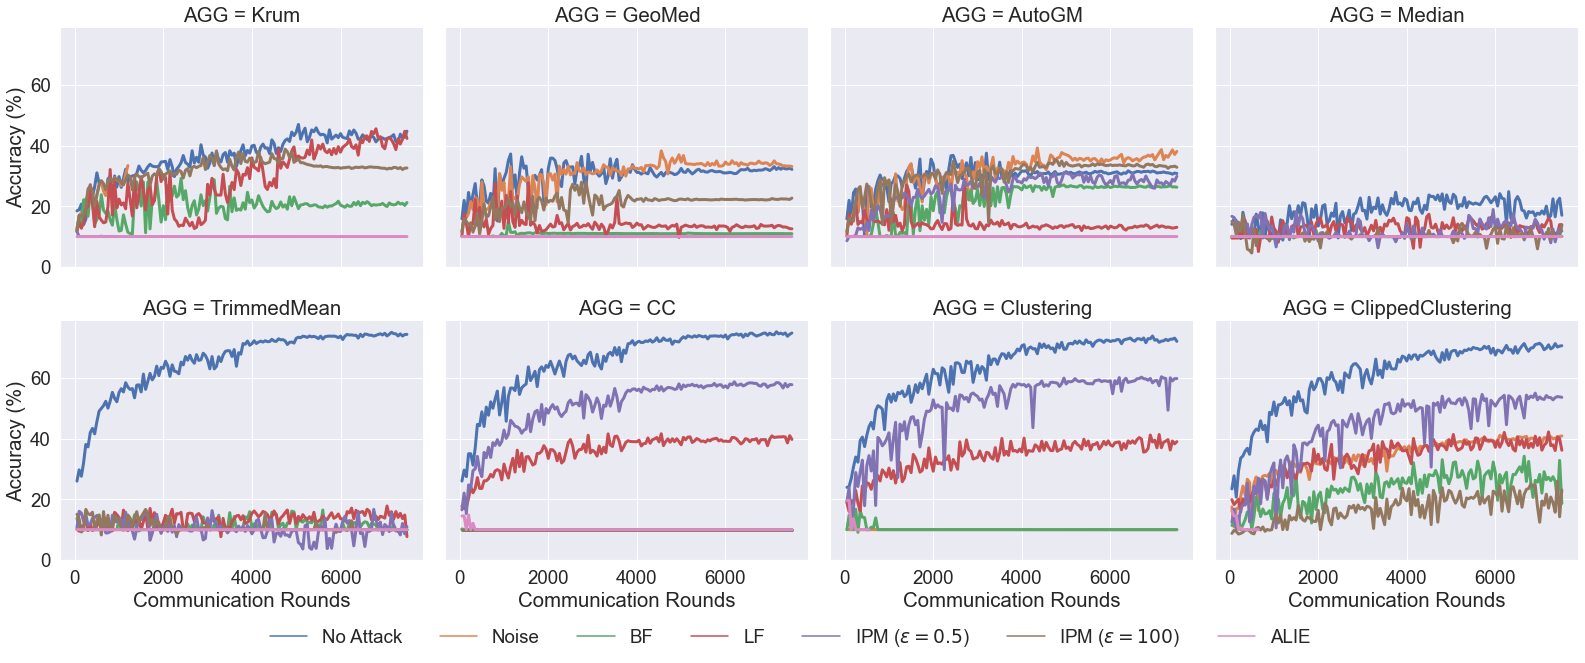

In [39]:
plot_all("fedsgd_noniid", 7500)

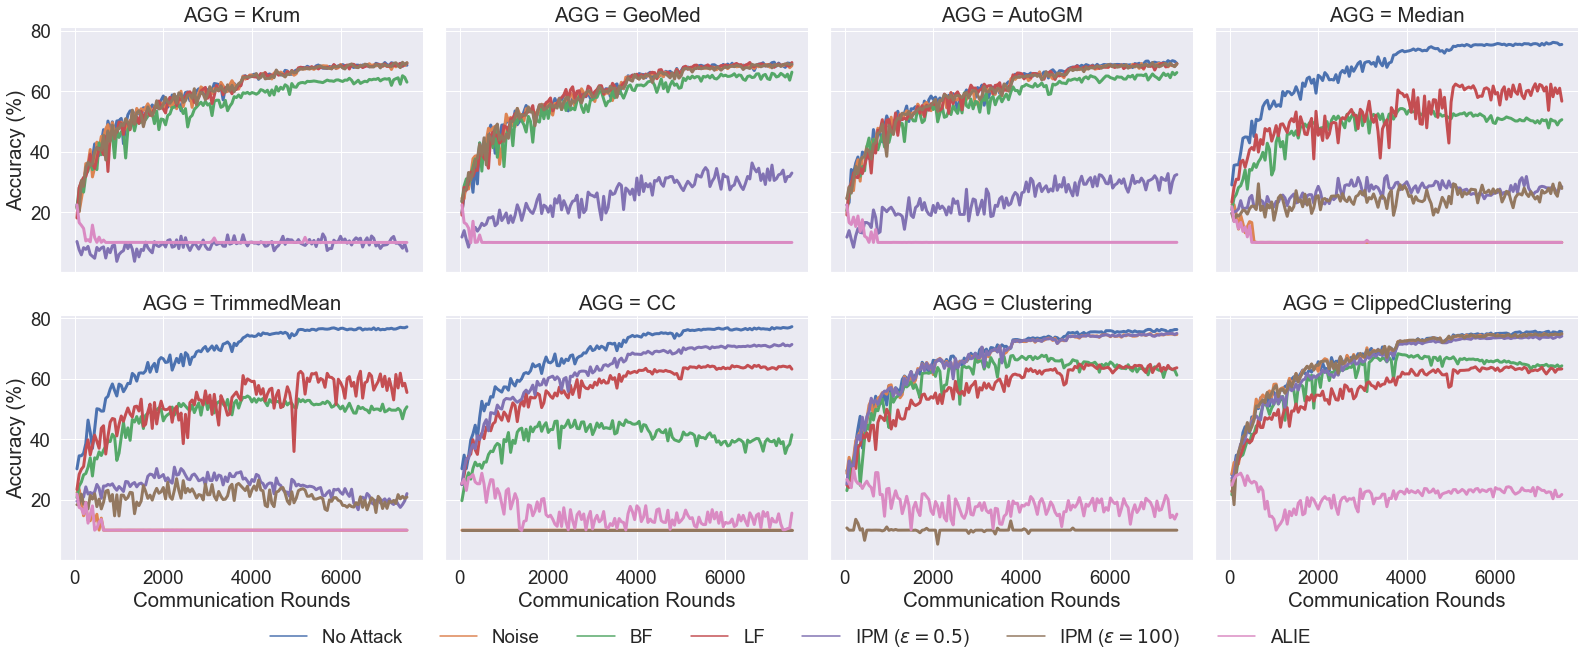

In [40]:
plot_all("fedsgd_iid", 7500)

In [41]:
data_collection = {}
df = []
avgs = ['avg']
ROOT_PATH="../outputs/{d}/f{f}_{atk}_{agg}_m{m}_seed{s}/stats"

b=[5]

attacks = ["ALIE", "IPM_large", 'IPM', "Noise"]
# attacks = ['IPM']
aggs = ["avg", "krum", 'rfa', "autogm", "cm", "tm", "cp", "clustering", 'clippedclustering']
aggs = ["krum", 'rfa', "autogm", "cm", "tm", "cp", "clustering", 'clippedclustering']
momentum = [0.0, 0.9]
fedavg_methods = {
    'avg' : {'name' : 'Mean', 'marker' : '^'}, 
    'rfa' : {'name' : 'GeoMed', 'marker' : 's'}, 
    'autogm' : {'name' : 'AutoGM', 'marker' : 's'}, 
    'krum' : {'name' : 'Krum', 'marker' : '|'}, 
    'cp' : {'name' : 'CC', 'marker' : 'p'}, 
    'cm': {'name' : 'Median', 'marker' : 'D'}, 
    'tm' : {'name' : 'TrimmedMean', 'marker' : '8'}, 
    'clustering' : {'name' : 'Clustering', 'marker' : 'o'}, 
    'clippedclustering' : {'name' : 'ClippedClustering', 'marker' : 'v'}
}

for dir_name in ['cifar10-all']:
    data_collection = append_loop_path(bs=b, seeds=[0], attacks=attacks, aggs=aggs, 
                    ms=momentum, dir_name=dir_name, data_collection=data_collection, ROOT_PATH=ROOT_PATH)
#     data_collection = append_loop_path(bs=b, seeds=[0], attacks=['IPM_large'], aggs=aggs, 
#                     ms=[0.0], dir_name=dir_name, data_collection=data_collection, ROOT_PATH=ROOT_PATH)
    
#     df = append_loop_df(bs=b, seeds=[0], attacks=['IPM_large'], aggs=aggs, 
#             ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection)
    df = append_loop_df(bs=b, seeds=[0], attacks=attacks, aggs=aggs, 
                    ms=momentum, dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection)
    
df = pd.DataFrame(df)
data = pd.DataFrame(df)
# data.loc[(data["Setting"] == "Fedsgd_iid") | (data["Setting"] == "Fedsgd_noniid"), "Round Number"] *= 50
data["Round Number"] *= 50
data["Communication Rounds"] = data["Round Number"]

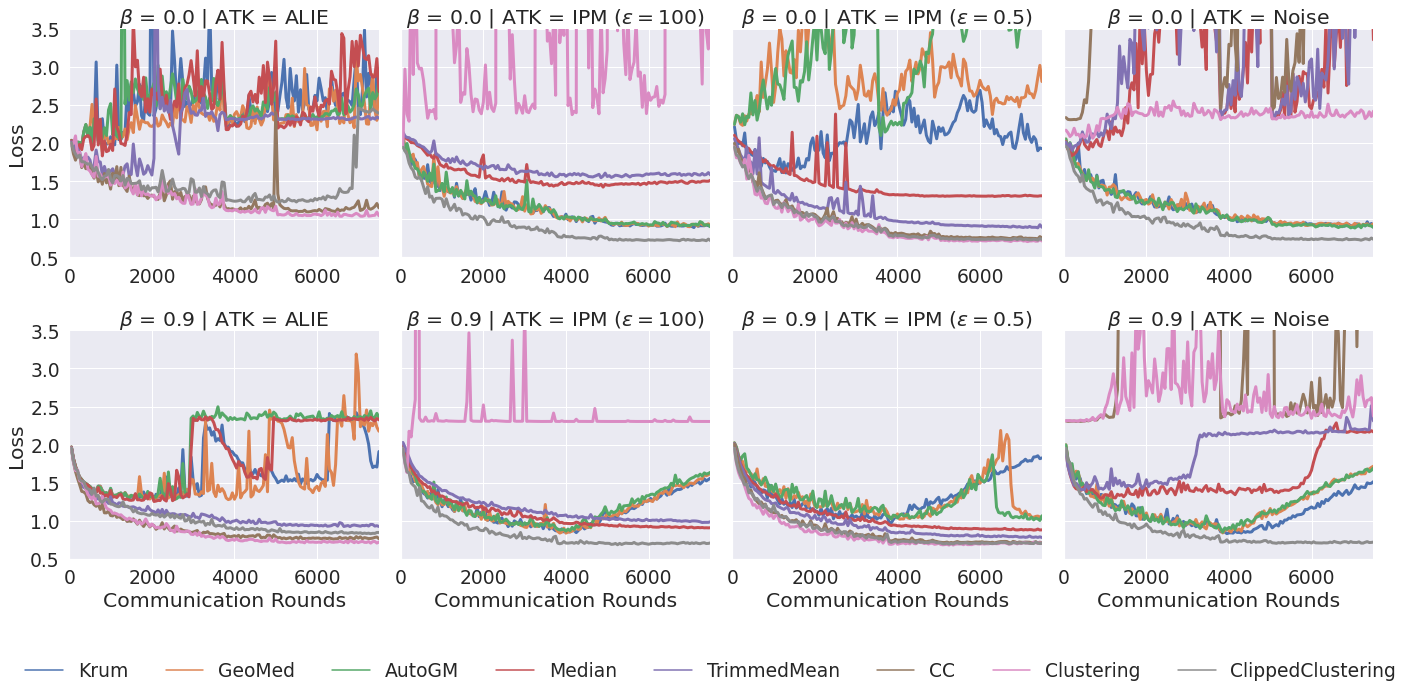

In [44]:
g = sns.relplot(
    data=data, 
    x="Communication Rounds", y="Loss", #y="Accuracy (%)", 
    col="ATK", 
    hue="AGG", 
    row=r"$\beta$",
    facet_kws={'sharey': True, 'sharex': False},
    height=4.5, aspect=1.1,
    markers=True,
#     col_wrap=3,
    linewidth = 3.0,
    kind="line"
)

g.set(ylim=(0.5, 3.5))
g.set(xlim=(0., 7500))
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.1), ncol=8, title=None, frameon=False)

g.savefig("momentum.pdf", bbox_inches = "tight") 

In [43]:
data_collection = {}
df = []
bzs = [32, 128, 512, 2500]
attack = ["ALIE"]
ROOT_PATH="../outputs/{d}/f{f}_{atk}_{agg}_m{m}_b{b}{bz}_seed{s}/stats"
# aggs += ["avg"]
for dir_name in ['fedsgd_iid']:
    data_collection = append_loop_path(bs=[8], seeds=[0], attacks=attack, aggs=["avg"] + aggs, 
                    ms=[0.0], dir_name=dir_name, data_collection=data_collection, ROOT_PATH=ROOT_PATH, bzs=bzs)
    
    df = append_loop_df(bs=[8], seeds=[0], attacks=attack, aggs=["avg"] + aggs, 
                    ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection, bzs=bzs)
    
data = pd.DataFrame(df)
data["Communication Rounds"] = data["Round Number"] * 50

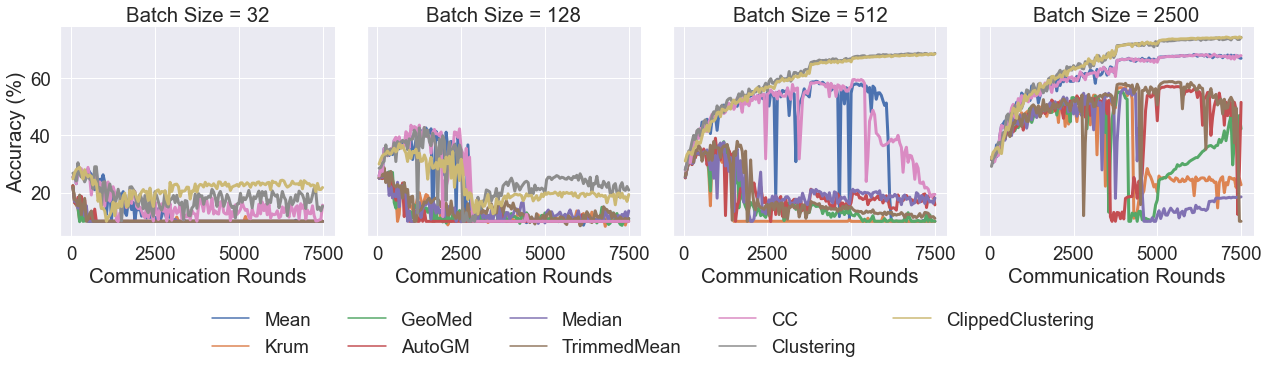

In [44]:
g = sns.relplot(
    data=data, 
    x="Communication Rounds", y="Accuracy (%)", 
    col="Batch Size", 
    hue="AGG", 
    facet_kws={'sharey': True, 'sharex': False},
    height=4.5, aspect=1,
    markers=True,
    col_wrap=4,
    linewidth = 3.0,
    kind="line"
)

sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.2), ncol=5, title=None, frameon=False)

g.savefig("batch_size.pdf", bbox_inches = "tight") 

In [45]:
data_collection = {}
df = []
bzs = [32]
bs = [2, 4, 6, 8]
attack = ["BF"]
ROOT_PATH="../outputs/{d}/f{f}_{atk}_{agg}_m{m}_b{b}{bz}_seed{s}/stats"
# aggs += ["avg"]
for dir_name in ['fedavg_iid']:
    data_collection = append_loop_path(bs=bs, seeds=[0], attacks=attack, aggs=["avg"] + aggs, 
                    ms=[0.0], dir_name=dir_name, data_collection=data_collection, ROOT_PATH=ROOT_PATH, bzs=bzs)
    
    df = append_loop_df(bs=bs, seeds=[0], attacks=attack, aggs=["avg"] + aggs, 
                    ms=[0.0], dir_name=dir_name, df=df, ROOT_PATH=ROOT_PATH, data_collection=data_collection, bzs=bzs)
    
data = pd.DataFrame(df)
data["Communication Rounds"] = data["Round Number"]

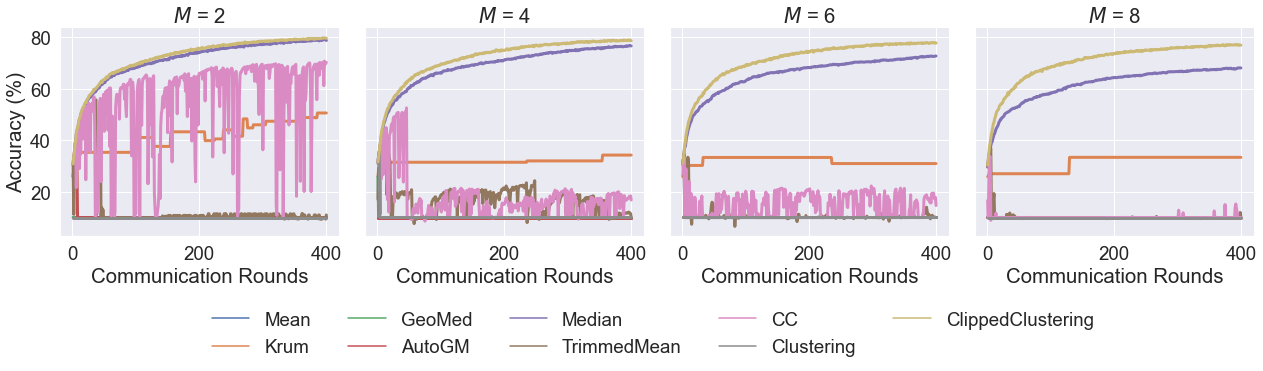

In [46]:
g = sns.relplot(
    data=data, 
    x="Communication Rounds", y="Accuracy (%)", 
    col=r"$M$", 
    hue="AGG", 
    facet_kws={'sharey': True, 'sharex': False},
    height=4.5, aspect=1,
    markers=True,
    col_wrap=4,
    linewidth = 3.0,
    kind="line"
)

sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.2), ncol=5, title=None, frameon=False)

g.savefig("num_byzantine.pdf", bbox_inches = "tight") 

/home/shenghui/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


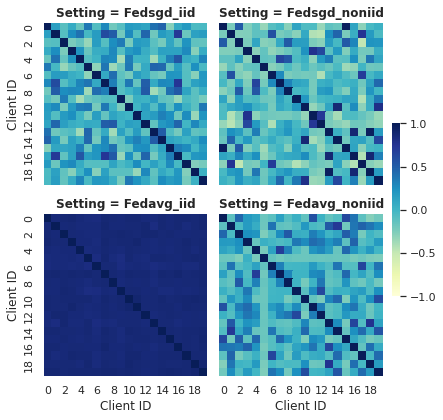

In [12]:
sim_sgd_noniid = np.load('updates_fedsgd_noniid.npy')
sim_avg_noniid = np.load('updates_fedavg_noniid.npy')
sim_sgd_iid = np.load('updates_fedsgd_iid.npy')
sim_avg_iid = np.load('updates_fedavg_iid.npy')
data = [("Setting = Fedsgd_iid", i, j, sim_sgd_iid[i,j]) for i in range(len(sim_avg_iid)) for j in range(len(sim_avg_iid))]
data.extend([("Setting = Fedsgd_noniid", i, j, sim_sgd_noniid[i,j]) 
                   for i in range(len(sim_avg_noniid)) 
                   for j in range(len(sim_avg_noniid))])
data.extend([("Setting = Fedavg_iid", i, j, sim_avg_iid[i,j]) 
                   for i in range(len(sim_avg_iid)) 
                   for j in range(len(sim_avg_noniid))])
data.extend([("Setting = Fedavg_noniid", i, j, sim_avg_noniid[i,j]) 
                   for i in range(len(sim_avg_noniid)) 
                   for j in range(len(sim_avg_noniid))])
df = pd.DataFrame(data, columns = ["Setting", 'i', 'j', 'value'])


methods=['method 1', 'method2', 'method 3', 'method 4']
times = range(0, 100, 10)
data = pd.DataFrame(list(itertools.product(methods, times, times)))
data.columns = ['method', 'dtsi','rtsi']
data['nw_score'] = np.random.sample(data.shape[0])

def facet_heatmap(data, color, **kws):
    data = data.pivot(index="i", columns='j', values='value')
    s = sns.heatmap(data, cmap='YlGnBu', center=0, **kws)  # <-- Pass kwargs to heatmap
    s.set(xlabel='Client ID', ylabel='Client ID')

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(df, col="Setting", col_wrap=2, height=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=-1, vmax=1)  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', fontsize=18)
g.fig.subplots_adjust(right=.9) 
g.savefig("similarity.pdf", bbox_inches = "tight")